In [34]:
# Import the libraries/files we want to run
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import importlib
# local files (stuff we wrote)
import DataProcessing
import ProjectMap
import BaseModel
import DualInputModel
import Analysis

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
#This allows changes to be reflected whenever we make them
importlib.reload(DataProcessing)
importlib.reload(BaseModel)
importlib.reload(DualInputModel)

GPU is available


<module 'DualInputModel' from '/mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/scripts/DualInputModel.py'>

In [19]:
# Get the directory layout of the project
PROJECT_MAP= ProjectMap.ProjectMap()
print(PROJECT_MAP)

Root: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project
Scripts: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/scripts
Data: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/data


In [20]:
# This gives us a reusable function to load data
# Odds are this is not how we will actually handle the data, it's just easy to do this for the base model
#Added in logic to bring in Plant ID dataset from - https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets?resource=download

training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.


In [21]:
# Working with the base model, not meant to be good, just a starting point
# Will probably be removed later
base_model= BaseModel.BaseModel()

layers = [
    keras.layers.Input(shape=(128, 128, 3)),
    keras.layers.Rescaling(1./255),  # normalize pixel values
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(classes), activation="softmax")
]

base_model.buildModel(layers)
base_model.compileModel()
#training_results= base_model.trainModel(training_data, val_data=val_data) 
#base_model.testModel(testing_data)

Model built
Model compiled


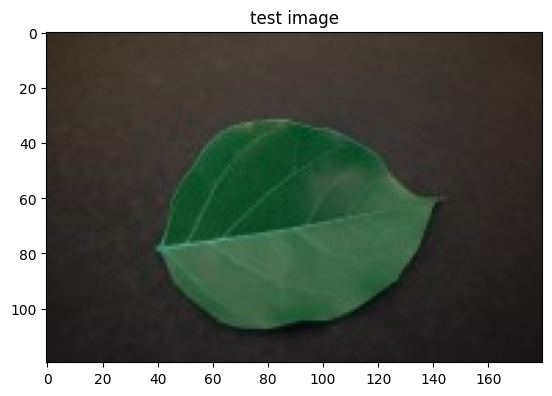

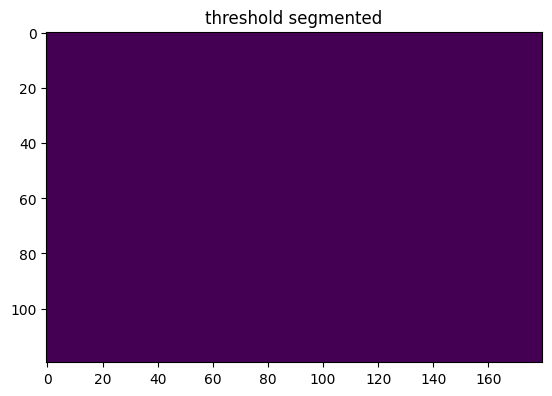

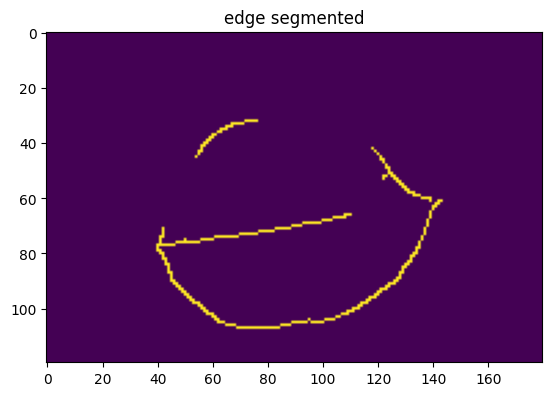

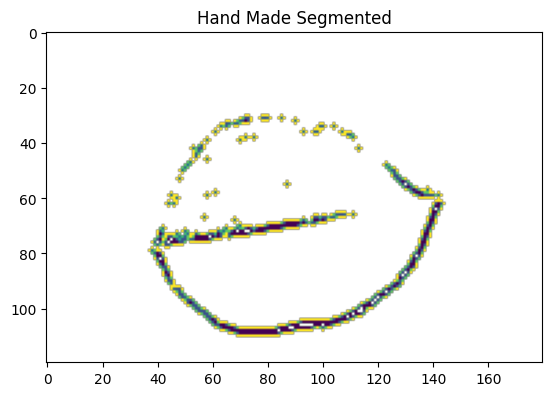

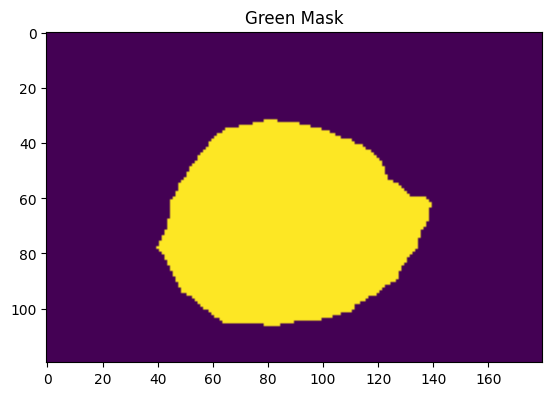

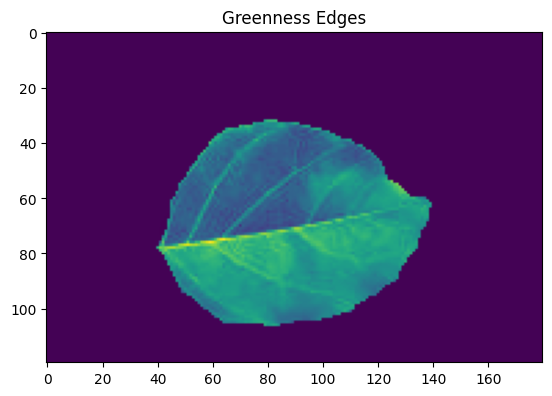

In [22]:
# Testing some of the segmentation code
# Will be removed later

test_image_path= os.path.join(PROJECT_MAP.dataDirectory, 'test.jpg')

test_image= DataProcessing.loadImage(test_image_path)
DataProcessing.displayImage(test_image, "test image")

segmented= DataProcessing.thresholdSegmentation(test_image, 150)
DataProcessing.displayImage(segmented, "threshold segmented")

edge_segmented= DataProcessing.edgeSegmentation(test_image, threshold=50)
DataProcessing.displayImage(edge_segmented, "edge segmented")

h_segmented= DataProcessing.handMadeSegmentation(test_image, 110)
DataProcessing.displayImage(h_segmented, "Hand Made Segmented")

#shows what mask output looks like
green_mask= DataProcessing.getGreennessMask(test_image)
DataProcessing.displayImage(green_mask, "Green Mask")

#shows what edges with CLAHE after greenness mask will look like
greenness_edges = DataProcessing.getEdgesFromGreenness(test_image)
DataProcessing.displayImage(greenness_edges, "Greenness Edges")


In [23]:
training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)
print(f'Classes: {classes}')
print(f'Len Classes: {len(classes)}')

for image, label in training_data.take(10):
    print("Label:", label.numpy())
#Creating dual sets
train_dual = DataProcessing.create_dual_input_dataset(training_data, DataProcessing.getEdgesFromGreenness)
val_dual = DataProcessing.create_dual_input_dataset(val_data, DataProcessing.getEdgesFromGreenness)
test_dual = DataProcessing.create_dual_input_dataset(testing_data, DataProcessing.getEdgesFromGreenness)

for (inputs, label) in train_dual.take(1):
    print("Raw shape:", inputs[0].shape)
    print("Mask shape:", inputs[1].shape)
    print("Label shape:", label.shape)

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.
Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']
Len Classes: 30
Label: 29
Label: 19
Label: 18
Label: 0
Label: 24
Label: 23
Label: 6
Label: 1
Label: 1
Label: 19
Raw shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)
Label shape: (32,)


In [24]:
for image, label in training_data.take(10):
    print("Label:", label.numpy())

Label: 7
Label: 9
Label: 8
Label: 11
Label: 22
Label: 20
Label: 24
Label: 15
Label: 22
Label: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..138.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..126.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input da

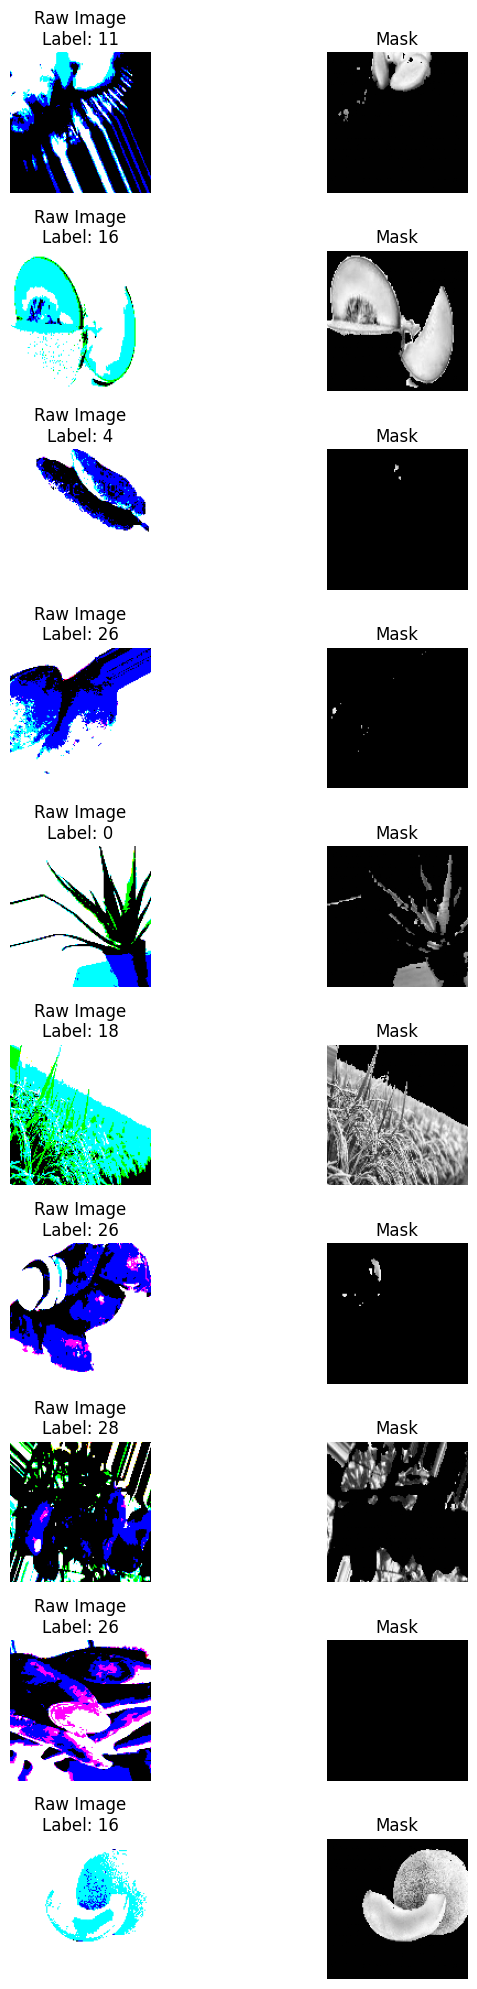

In [25]:
DataProcessing.displayProcessedImages(train_dual, 10)

In [30]:
dual_model = DualInputModel.DualInputModel(num_classes=30)
dual_model.buildModel()

training_metrics= [
    'accuracy',
    keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_3_accuracy'),
    keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
]

dual_model.compileModel(metrics=training_metrics)
training_results= dual_model.trainModel(train_dual, val_data=val_dual, epochs=10) 
test_predictions, labels, test_accuracy, test_report= dual_model.testModel(test_dual)

Model compiled
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.3940 - loss: 2.3512 - top_10_accuracy: 0.8092 - top_3_accuracy: 0.3940 - val_accuracy: 0.7653 - val_loss: 0.7512 - val_top_10_accuracy: 0.9861 - val_top_3_accuracy: 0.7653
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.7526 - loss: 0.8062 - top_10_accuracy: 0.9836 - top_3_accuracy: 0.7526 - val_accuracy: 0.8257 - val_loss: 0.5384 - val_top_10_accuracy: 0.9974 - val_top_3_accuracy: 0.8257
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8218 - loss: 0.5612 - top_10_accuracy: 0.9947 - top_3_accuracy: 0.8218 - val_accuracy: 0.8380 - val_loss: 0.5246 - val_top_10_accuracy: 0.9967 - val_top_3_accuracy: 0.8380
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.8560 - loss: 0.4475 - top_10_accuracy: 0.9964 - top_3_accuracy: 0.8560 - val_accuracy: 0.8693 - val_loss: 0.4100 - val_top_10_accuracy: 0.9980 - val_top_3_accuracy: 0.8693
Epoch 5/10
750/750 ━━━━━━

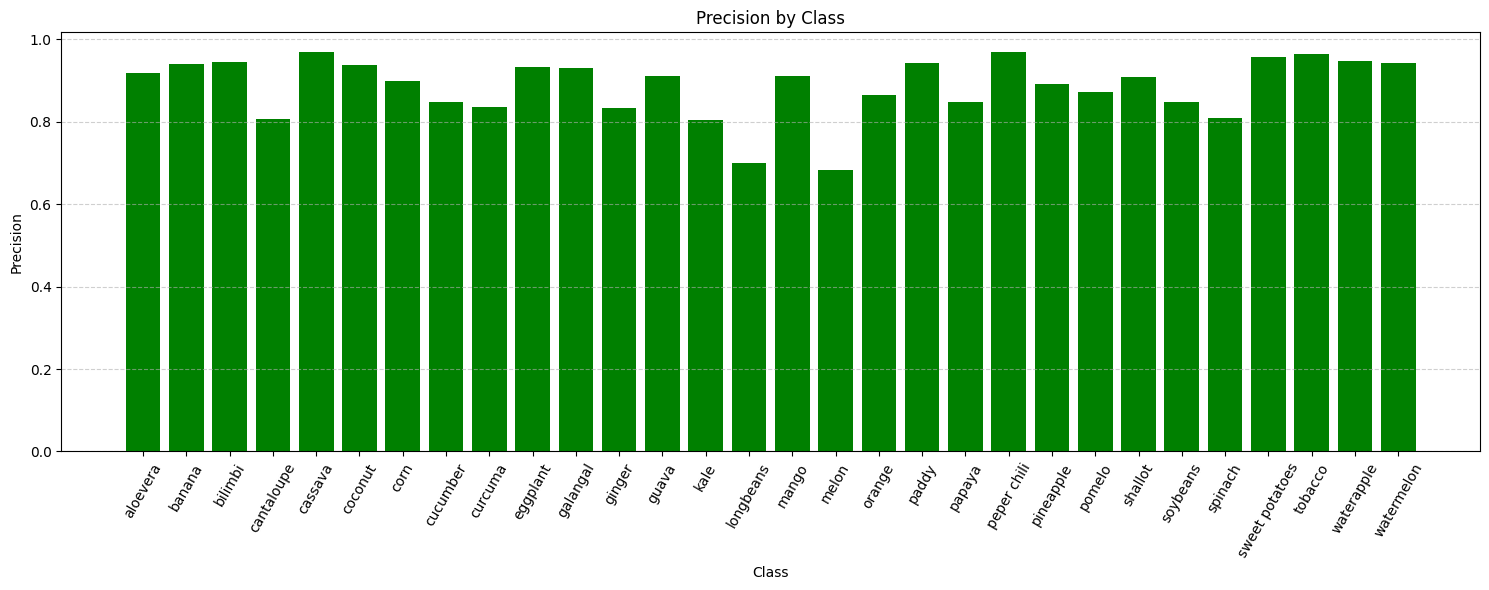

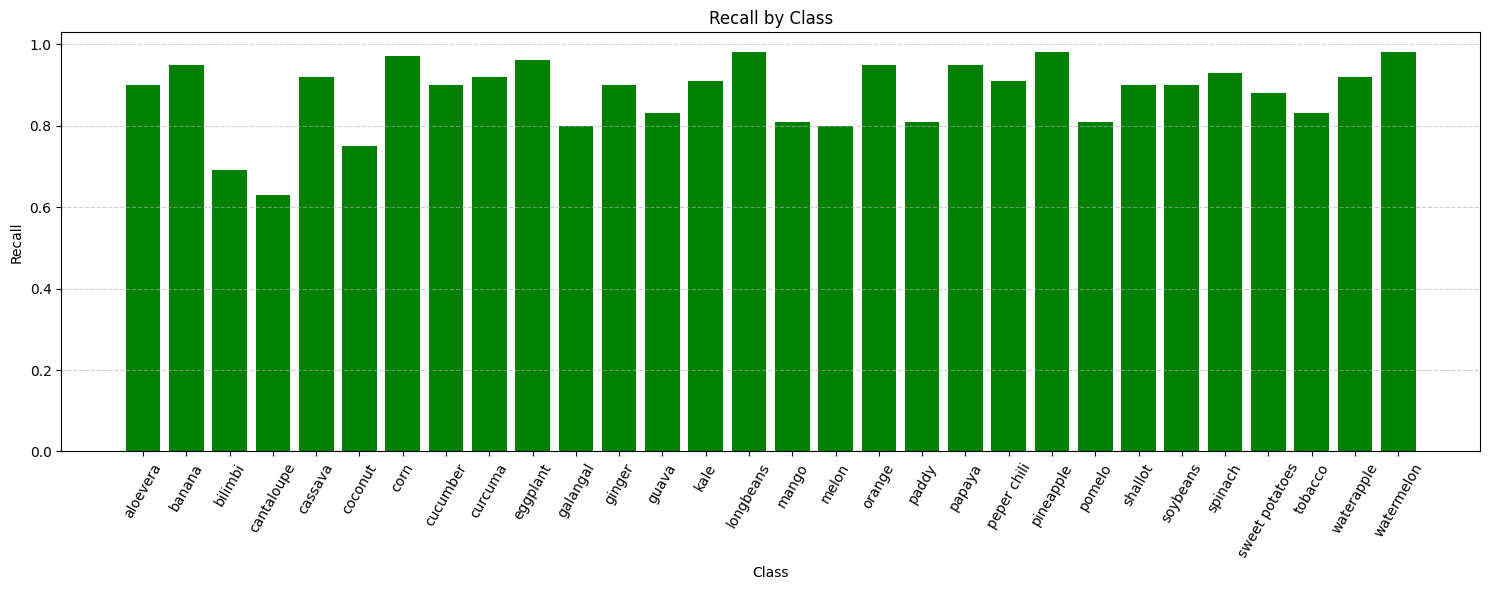

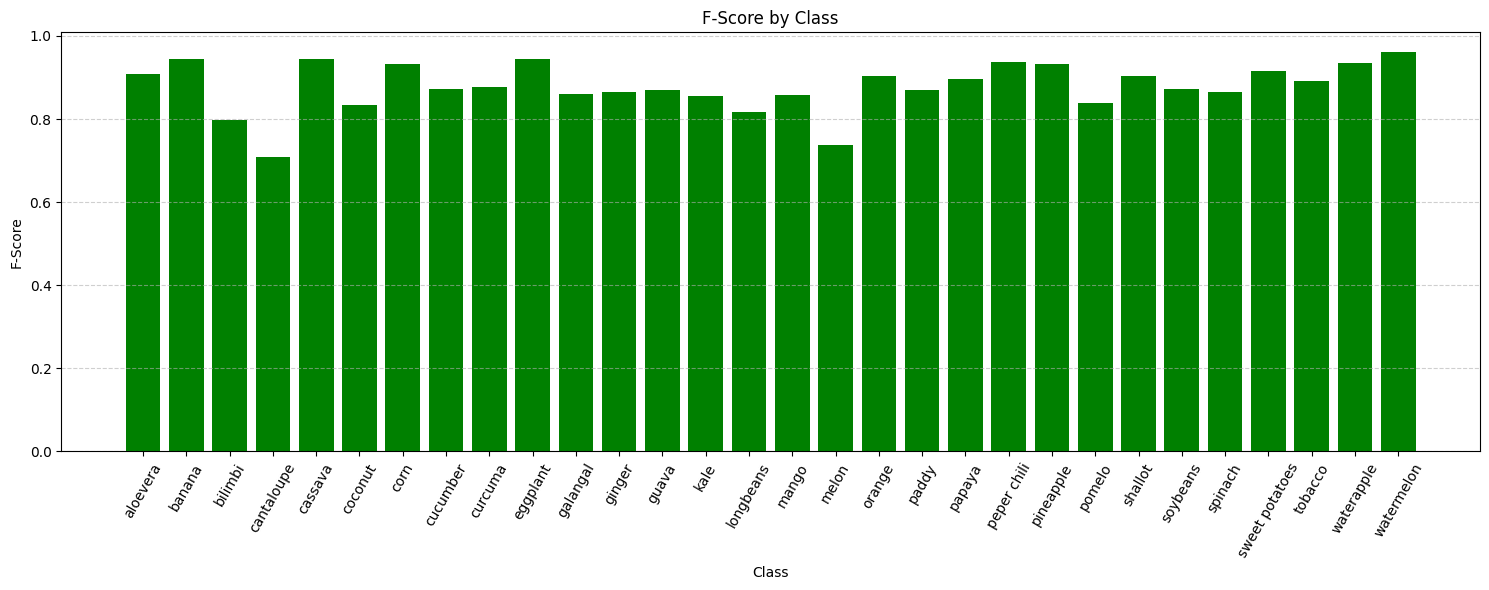

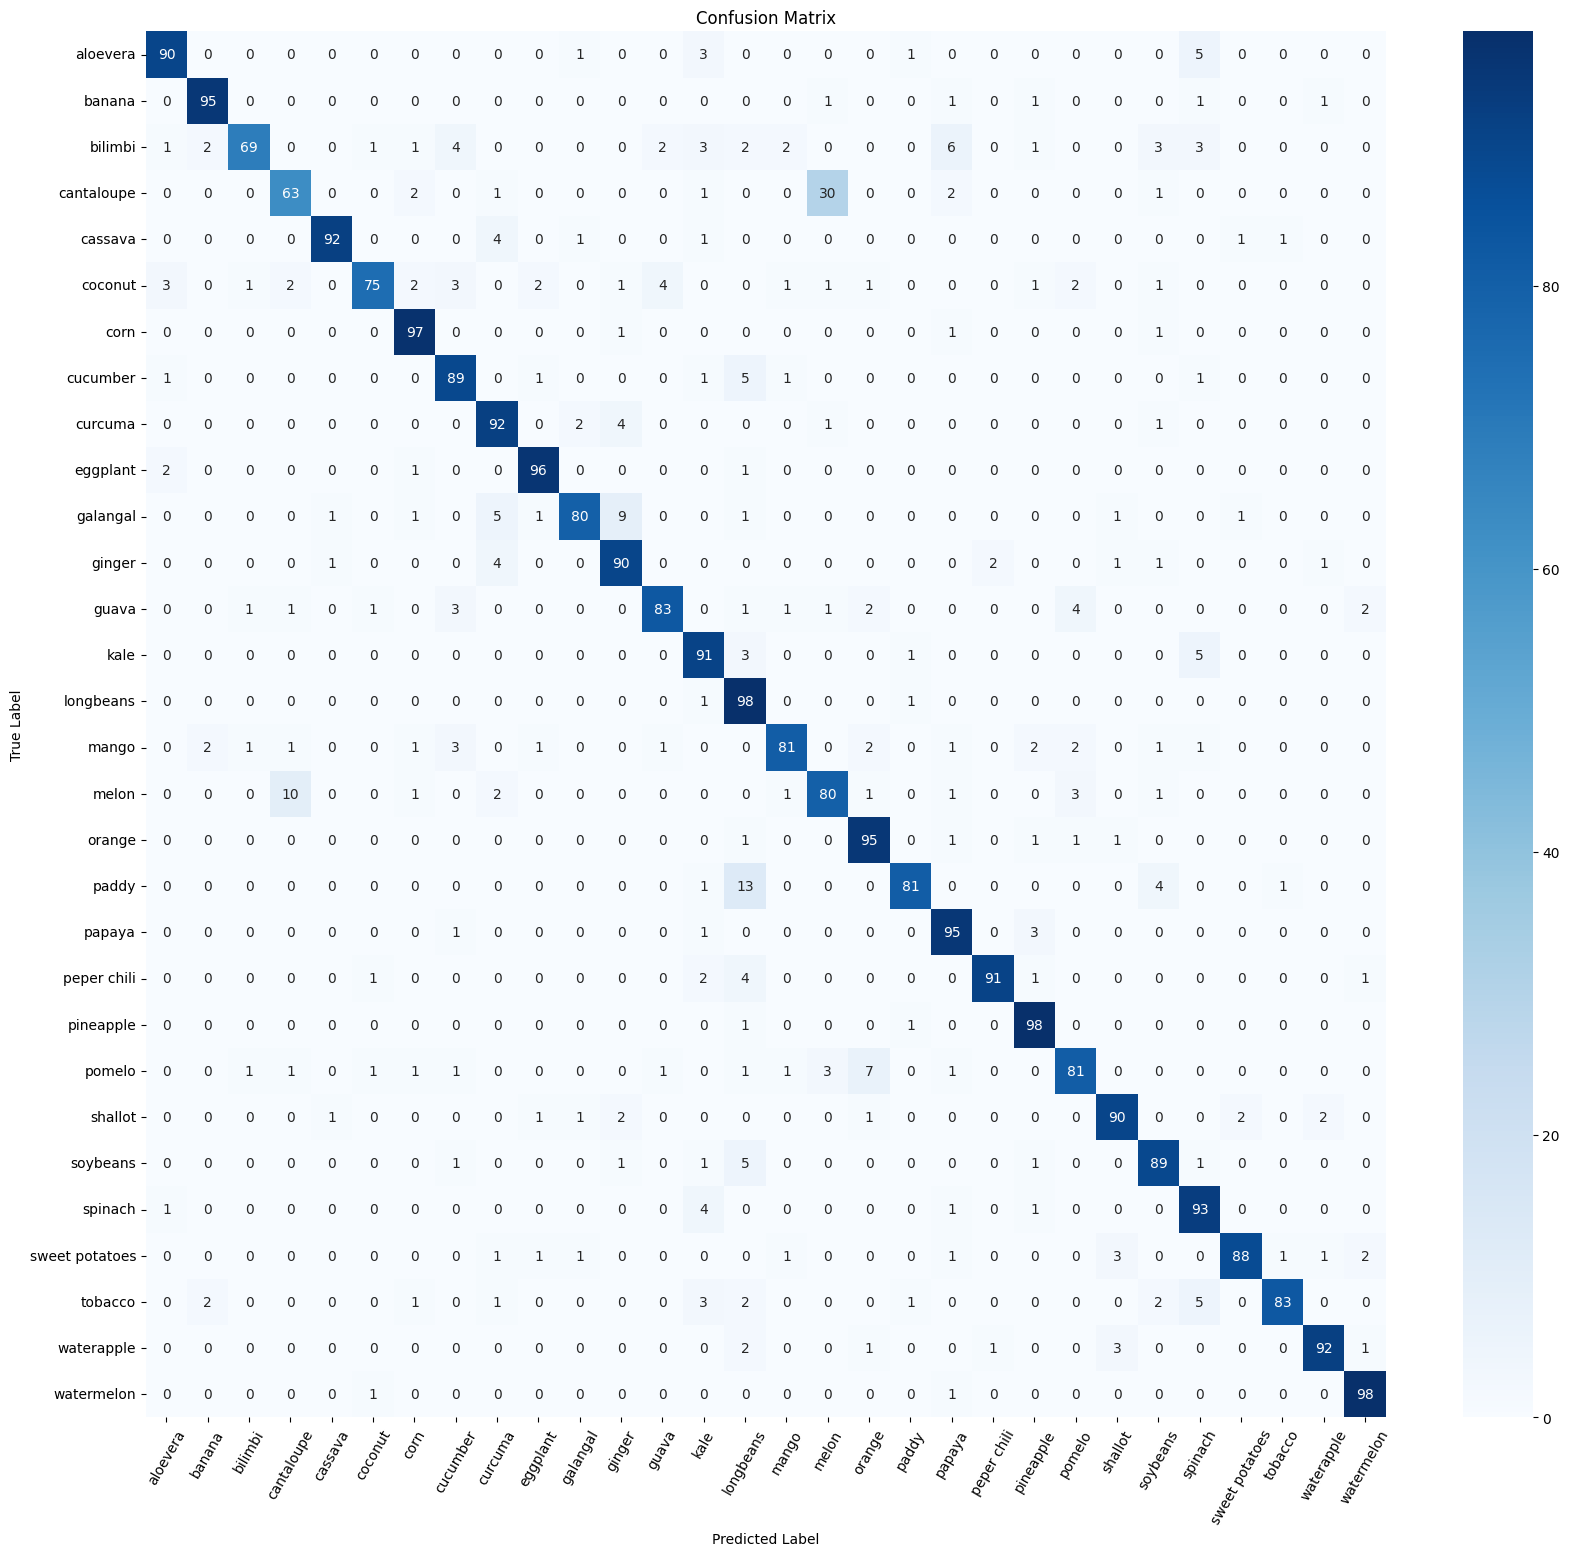

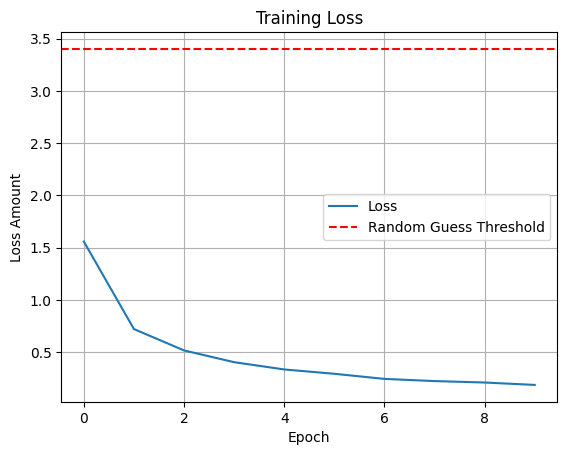

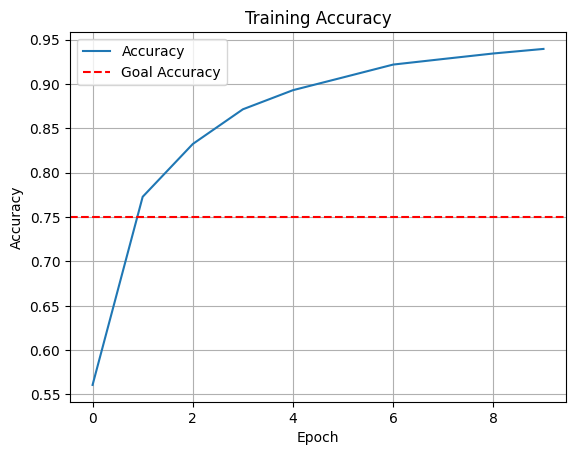

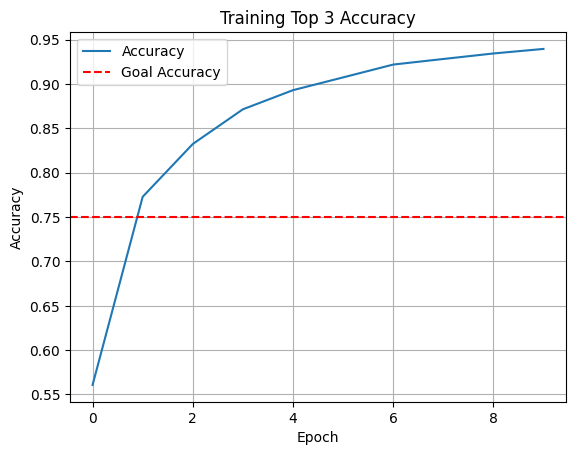

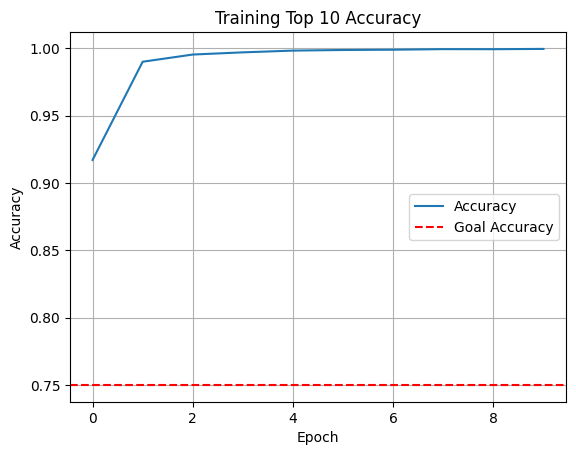

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        320 │ mask_input[0][0]

 Total params: 20,858,396 (79.57 MB)

 Trainable params: 277,854 (1.06 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 555,710 (2.12 MB)

In [27]:
# make some graphs and whatnot for analysis
# Most of the function are defined in the Analysis.py file
import Analysis
    
class_names= training_data.class_names

training_loss= training_results.history['loss']
training_accuracy= training_results.history["accuracy"]
top_3_accuracy= training_results.history["top_3_accuracy"]
top_10_accuracy= training_results.history['top_10_accuracy']

precision, recall, fscore, support= Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model.model.summary()


In [35]:
dual_model_best = DualInputModel.DualInputModel(num_classes=30)
best_model_best = dual_model.optimize_hyperparameters(train_dual, val_dual, test_dual, model_builder=dual_model_best.buildHPModel)
training_results_best = dual_model_best.trainModel(train_dual, val_data=val_dual, epochs=10)
test_predictions, labels, test_accuracy, test_report= dual_model.testModel(test_dual)

Reloading Tuner from plant_tuner/plant_model/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |64                |dense1_units
192               |64                |dense2_units
512               |512               |dense3_units
0.3               |0.3               |dropout1
128               |128               |dense4_units
0.1               |0.3               |dropout2
0.001             |0.001             |learning_rate

Epoch 1/10


2025-07-20 16:59:53.396217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1627', 188 bytes spill stores, 188 bytes spill loads

2025-07-20 16:59:53.567712: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3001', 4 bytes spill stores, 4 bytes spill loads

2025-07-20 16:59:53.612865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2988', 56 bytes spill stores, 56 bytes spill loads

2025-07-20 16:59:53.881904: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 4 bytes spill stores, 4 bytes spill loads

2025-07-20 16:59:54.037885: I external/loc

748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4442 - loss: 2.0479 - top_10_accuracy: 0.8514 - top_3_accuracy: 0.6512

2025-07-20 17:00:24.918743: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1627', 8 bytes spill stores, 8 bytes spill loads

2025-07-20 17:00:25.077647: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 4 bytes spill stores, 4 bytes spill loads

2025-07-20 17:00:25.089055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1627', 104 bytes spill stores, 104 bytes spill loads

2025-07-20 17:00:25.134270: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 8 bytes spill stores, 8 bytes spill loads

2025-07-20 17:00:25.498989: I external/local

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4446 - loss: 2.0461 - top_10_accuracy: 0.8516 - top_3_accuracy: 0.6516

2025-07-20 17:00:27.855087: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_375_0', 44 bytes spill stores, 44 bytes spill loads

2025-07-20 17:00:27.937618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_375', 484 bytes spill stores, 484 bytes spill loads

2025-07-20 17:00:31.744797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_360', 4 bytes spill stores, 4 bytes spill loads

2025-07-20 17:00:31.847569: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_375_0', 36 bytes spill stores, 36 bytes spill loads

2025-07-20 17:00:31.910392: I external/l

750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.4448 - loss: 2.0452 - top_10_accuracy: 0.8517 - top_3_accuracy: 0.6518 - val_accuracy: 0.7667 - val_loss: 0.7461 - val_top_10_accuracy: 0.9901 - val_top_3_accuracy: 0.9333
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7791 - loss: 0.7003 - top_10_accuracy: 0.9916 - top_3_accuracy: 0.9399 - val_accuracy: 0.8129 - val_loss: 0.5800 - val_top_10_accuracy: 0.9964 - val_top_3_accuracy: 0.9548
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8445 - loss: 0.4795 - top_10_accuracy: 0.9966 - top_3_accuracy: 0.9674 - val_accuracy: 0.8241 - val_loss: 0.5752 - val_top_10_accuracy: 0.9970 - val_top_3_accuracy: 0.9554
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.8741 - loss: 0.3817 - top_10_accuracy: 0.9978 - top_3_accuracy: 0.9770 - val_accuracy: 0.8637 - val_loss: 0.4218 - val_top_10_accuracy: 0.9990 - val_top_3_accuracy: 0.9716
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/st

KeyboardInterrupt: 

In [ ]:
class_names= training_data.class_names

training_loss= training_results_best.history['loss']
training_accuracy= training_results_best.history["accuracy"]
top_3_accuracy= training_results_best.history["top_3_accuracy"]
top_10_accuracy= training_results_best.history['top_10_accuracy']

precision, recall, fscore, support= Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model.model.summary()

In [36]:
best_model_best.model.save("best_plant_model.keras")

NameError: name 'best_model_best' is not defined